In [1]:
!pip install datasets transformers albumentations huggingface_hub

In [1]:
# NEW ALGO #

"""
to deal with inconsistently labelled data
we will train our model on the original data
then we will use the output maps from this model
and combine them with original maps using (logical OR)
then re-train and check results

"""

'\nto deal with inconsistently labelled data\nwe will train our model on the original data\nthen we will use the output maps from this model\nand combine them with original maps using (logical OR)\nthen re-train and check results\n\n'

In [2]:
from datasets import load_dataset

# v1 is original RGB dataset
# v2 is with some extra preprocessing that was needed for maskformer (not needed in upernet)
# v3 is with RGB + NIR channel dataset (poor performance on this one)

dataset = load_dataset("jaygala223/38-cloud-train-only-v1")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/jaygala223--38-cloud-train-only-v1-db1b4c66d07f8975/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8400
    })
})

In [5]:
# # exclude bad labels

# bad_labels = [35, 36]

# dataset['train'] = dataset['train'].select(
#     (
#         i for i in range(dataset['train'].num_rows)
#         if i not in set(bad_labels)
#     )
# )

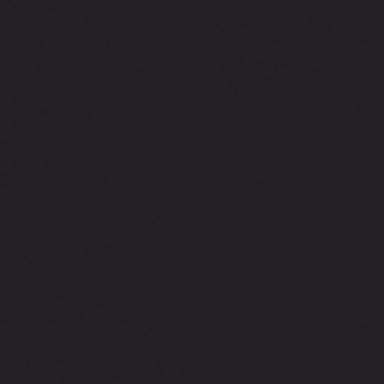

In [5]:
dataset['train'][2500]['image']

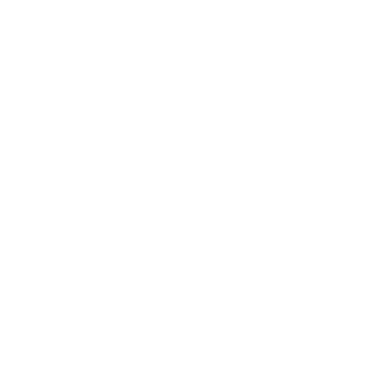

In [6]:
dataset['train'][2500]['label']

In [8]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.01)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [9]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 8316
})
Dataset({
    features: ['image', 'label'],
    num_rows: 84
})


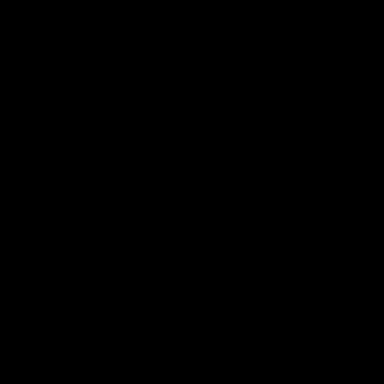

In [9]:
# let's look at one example
example = train_ds[39]
image = example['image']
image

In [10]:
import numpy as np
np.array(image).shape

(384, 384, 3)

In [11]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])/255
segmentation_map = np.array(segmentation_map, dtype=np.uint8)
segmentation_map

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
np.unique(segmentation_map)

array([0], dtype=uint8)

In [10]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"jaygala223/38-cloud-train-only-v2"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'non-cloud', 1: 'cloud'}


In [14]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    # return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
    #         [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
    #         [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
    #         [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
    #         [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
    #         [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
    #         [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
    #         [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
    #         [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
    #         [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
    #         [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
    #         [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
    #         [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
    #         [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
    #         [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
    #         [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
    #         [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
    #         [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
    #         [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
    #         [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
    #         [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
    #         [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
    #         [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
    #         [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
    #         [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
    #         [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
    #         [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
    #         [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
    #         [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
    #         [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
    #         [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
    #         [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
    #         [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
    #         [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
    #         [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
    #         [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
    #         [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
    #         [102, 255, 0], [92, 0, 255]]

    #since we only have 2 classes
    return [[102, 255, 0], [92, 0, 255]]

palette = color_palette()

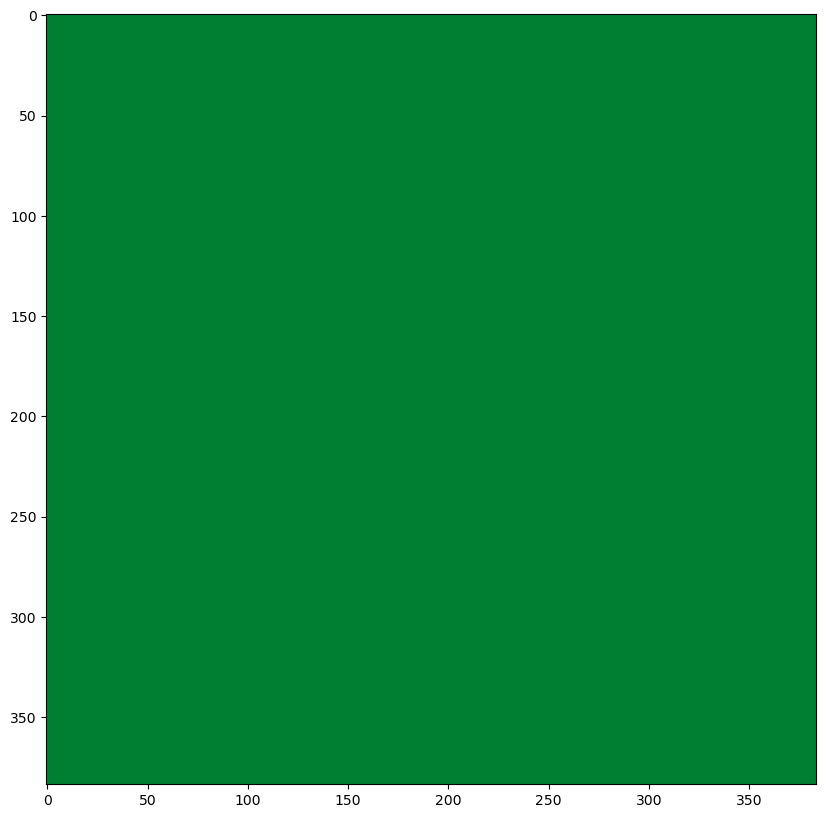

In [15]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [11]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        # adding one bottom most pixel as 255 since processor/feature_extractor
        # wont take labels without a positive (i.e. class: 1 or cloud)
        uniques = np.unique(original_segmentation_map)
        if sum(uniques) == 0:
            original_segmentation_map[-1, -1] = 255

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [12]:
import albumentations as A


ADE_MEAN = np.array([100, 100, 100]) / 255
ADE_STD = np.array([100, 100, 100]) / 255

train_transform = A.Compose([
    # A.LongestMaxSize(max_size=384),
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    # A.Resize(width=100, height=100),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# train_dataset = ImageSegmentationDataset(train_ds)
train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)
# test_dataset = ImageSegmentationDataset(test_ds)

In [13]:
# image, segmentation_map, _, _ = train_dataset[0]
image, segmentation_map, _, _ = train_dataset[222]
print(image.shape)
print(segmentation_map.shape)

(3, 384, 384)
(384, 384)


In [14]:
from transformers import MaskFormerImageProcessor,Mask2FormerImageProcessor, AutoImageProcessor

# Create a preprocessor
# preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                   do_reduce_labels=False,
#                                                   do_resize=False, do_rescale=False, do_normalize=False)

size = {'longest_edge':384, 'shortest_edge':384}

#original
preprocessor = MaskFormerImageProcessor(ignore_index=0,
                                        do_reduce_labels=False,
                                        do_resize=False,
                                        do_rescale=False,
                                        do_normalize=False,
                                        size=size)


#my experiment
# preprocessor = Mask2FormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [15]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

In [16]:

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# batch size more than 2 causes CUDA out of memory error

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [17]:
import torch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])
mask_labels torch.Size([1, 384, 384])
class_labels torch.Size([1])
original_images (384, 384, 3)
original_segmentation_maps (384, 384)


In [46]:
from transformers import MaskFormerForInstanceSegmentation, Mask2FormerForUniversalSegmentation

# Replace the head of the pre-trained model

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic",
#                                                             id2label=id2label,
#                                                             ignore_mismatched_sizes=True)


from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-ade-semantic",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# model = MaskFormerForInstanceSegmentation.from_pretrained("jaygala223/maskformer-finetuned-for-38-cloud-dataset",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation, AutoImageProcessor, UperNetForSemanticSegmentation
from PIL import Image
import requests

size = {'longest_edge':384, 'shortest_edge':383}

# load MaskFormer fine-tuned on COCO panoptic segmentation
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-ade",
                                                               size=size,
                                                               )

# model 1 is for generating new pred segmentation maps... model 2 is to train on new pred labels

# image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-tiny")
# model1 = UperNetForSemanticSegmentation.from_pretrained("jaygala223/upernet-swin-tiny-finetuned-for-38-cloud-dataset")
# model2 = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-tiny")

/opt/conda/lib/python3.10/site-packages/transformers/models/maskformer/feature_extraction_maskformer.py:28: FutureWarning: The class MaskFormerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MaskFormerImageProcessor instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/maskformer/image_processing_maskformer.py:401: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/maskformer/image_processing_maskformer.py:408: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


In [47]:
import torch
device = "cuda"
batch = next(iter(train_dataloader))

images, labels = batch['original_images'], batch['original_segmentation_maps']

# first convert to np array then to tensor... because list to tensor is a slow operation
images = np.array(images)
images = torch.tensor(images)/255
labels = np.array(labels)
labels = torch.tensor(labels)/255

images.to(device)
labels.to(device)
model.to(device)

inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

inputs['mask_labels'] = torch.stack(inputs['mask_labels']).to(device)
inputs['class_labels'] = torch.stack(inputs['class_labels']).to(device)

inputs['pixel_values'] = inputs['pixel_values'].float()

inputs.to(device)
outputs = model(**inputs)

# target_sizes1 = [(image.shape[0], image.shape[1]) for image in images]

# predicted_segmentation_maps1 = image_processor.post_process_semantic_segmentation(outputs1,
#                                                                                   target_sizes=target_sizes1)

# # generate new labels using OR only when the map contains 0s and 1s both
# for label, pred_map in zip(labels, predicted_segmentation_maps1):
#     if len(torch.unique(label)) == 2:
#         label = torch.logical_or(label.to(device), pred_map.to(device))

# # labels = torch.logical_or(labels.to(device), torch.stack(predicted_segmentation_maps1).to(device))

# inputs2 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

# inputs2.to(device)

# # train on new labels to tackle label inconsistency
# outputs2 = model(**inputs2)

print("done!")

done!


In [48]:
print(outputs.loss)

tensor([5.8003], device='cuda:0', grad_fn=<AddBackward0>)


TRAINING

In [49]:
import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cuda"
# model1.to(device)
# model2.to(device)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

running_loss = 0.0
num_samples = 0
epoch = 0
while True:
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)

      inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs['mask_labels'] = torch.stack(inputs['mask_labels']).to(device)
      inputs['class_labels'] = torch.stack(inputs['class_labels']).to(device)

      inputs['pixel_values'] = inputs['pixel_values'].float()

      inputs.to(device)
      outputs = model(**inputs)

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)
        if (running_loss/num_samples) <= 0.10:
            break

      # Optimization
      optimizer.step()

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 1.632333517074585
Loss: 1.817739243554597
Loss: 1.9195999778918367
Loss: 1.8281616320047664
Loss: 1.814513649503489
Loss: 1.7508054649282596
Loss: 1.6509112423152574
Loss: 1.561789102629146
Loss: 1.5047676313049934
Loss: 1.4637528150843728
Loss: 1.4810838697182311
Loss: 1.454806758133148
Loss: 1.4081386912189158
Loss: 1.3788968402660415
Loss: 1.3626250615190558
Loss: 1.3569363114696436
Loss: 1.338132301237269
Loss: 1.3377836339004876
Loss: 1.3254531599014485
Loss: 1.3021387374680147
Loss: 1.2841927439182892
Loss: 1.2622145132925442
Loss: 1.2594215983777954
Loss: 1.245373584857872
Loss: 1.2320791152257415
Loss: 1.2166683752445735
Loss: 1.2115849342278817
Loss: 1.2029194362359503
Loss: 1.194346092883411
Loss: 1.1812900196721086
Loss: 1.1714316340177626
Loss: 1.1634967535859113
Loss: 1.1698431199982702
Loss: 1.163704794104516
Loss: 1.1539686999007976
Loss: 1.147016531976418
Loss: 1.1376792279979118
Loss: 1.1351252252613973
Loss: 1.133835551798171
Loss: 1.129211963216209
Loss: 1.1193

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 1.0449484474495638
Loss: 1.0419520941704912
Loss: 1.0411120201901145
Loss: 1.0382528355868452
Loss: 1.0368185605662767
Loss: 1.0342307243125637
Loss: 1.0319496456463066
Loss: 1.0286266982664458
Loss: 1.0255379770120678
Loss: 1.0230064779710806
Loss: 1.0199454721238104
Loss: 1.0175817696180036
Loss: 1.0158123103941865
Loss: 1.0137408058565496
Loss: 1.0119966409745451
Loss: 1.0091446114767955
Loss: 1.0073140958008344
Loss: 1.0056118394272453
Loss: 1.0039353443544774
Loss: 1.0028474269763148
Loss: 1.0002599411471715
Loss: 0.9990246673278654
Loss: 0.9962219883383788
Loss: 0.9940660988114262
Loss: 0.9921852459633451
Loss: 0.9890939600499146
Loss: 0.9871542340522776
Loss: 0.9845316079410946
Loss: 0.9822043998072588
Loss: 0.9805043484111292
Loss: 0.9783307664656614
Loss: 0.9763562904139466
Loss: 0.9746697016705331
Loss: 0.972422603347492
Loss: 0.971779602329316
Loss: 0.9690375099395389
Loss: 0.967068176975714
Loss: 0.9667809226143982
Loss: 0.9658462188094473
Loss: 0.9658233540658183
Los

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.9123630151269075
Loss: 0.9106187951591148
Loss: 0.9096362623720537
Loss: 0.9084179337020781
Loss: 0.9070852674429691
Loss: 0.9056897212555031
Loss: 0.9045513103950243
Loss: 0.9037804703557494
Loss: 0.9027604904488009
Loss: 0.9015902124272211
Loss: 0.9008308545324138
Loss: 0.8999001042623158
Loss: 0.8990371223999318
Loss: 0.898130396002218
Loss: 0.8968422113136527
Loss: 0.8956466576665179
Loss: 0.8942817440526684
Loss: 0.8932247366111037
Loss: 0.8925346175300339
Loss: 0.891802486754471
Loss: 0.8901279078136638
Loss: 0.8891678965966541
Loss: 0.8880157673700094
Loss: 0.887100861501229
Loss: 0.8862383858724643
Loss: 0.8865717643151397
Loss: 0.8861282235345094
Loss: 0.8849286742075628
Loss: 0.8839013430624487
Loss: 0.8826984303252419
Loss: 0.8814988992229746
Loss: 0.8803080223379529
Loss: 0.879272251853915
Loss: 0.8783926484203761
Loss: 0.8774955573479711
Loss: 0.8767539961896816
Loss: 0.8758780483600355
Loss: 0.875027163136784
Loss: 0.873538383671376
Loss: 0.8733727907330946
Loss: 

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.8383214385995115
Loss: 0.8378626937200944
Loss: 0.8371708284115629
Loss: 0.8365159064384965
Loss: 0.8357686374577936
Loss: 0.8348522633258507
Loss: 0.8340979829122047
Loss: 0.8334566559930857
Loss: 0.8323712071250575
Loss: 0.8312793650764082
Loss: 0.8303683381681991
Loss: 0.8295433175471885
Loss: 0.8287413570293505
Loss: 0.8277327344167813
Loss: 0.8269003873193367
Loss: 0.8262235070085961
Loss: 0.8255498244036115
Loss: 0.8249295822921813
Loss: 0.8239851811397071
Loss: 0.82327443074126
Loss: 0.8225059196822404
Loss: 0.8217504692870815
Loss: 0.8209151916803873
Loss: 0.8201125578730538
Loss: 0.8194183194912776
Loss: 0.819063050385303
Loss: 0.8184661992388355
Loss: 0.817356563348828
Loss: 0.8165721095649493
Loss: 0.8156556244163046
Loss: 0.8148409378829454
Loss: 0.8142729833869007
Loss: 0.8135913733577306
Loss: 0.8128411047848477
Loss: 0.8120893109752104
Loss: 0.8115465521263512
Loss: 0.810807465845125
Loss: 0.8106708860916115
Loss: 0.8100153478077255
Loss: 0.808876182673624
Loss: 

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.7822673160567662
Loss: 0.7815594344673558
Loss: 0.7809031929294794
Loss: 0.7802048857442165
Loss: 0.7795922283351545
Loss: 0.7810863067288275
Loss: 0.7815296476424427
Loss: 0.7813153224075496
Loss: 0.7808670731683223
Loss: 0.7804031903362241
Loss: 0.7801635589945818
Loss: 0.779532161324774
Loss: 0.778835917200991
Loss: 0.7779797042005059
Loss: 0.7772929736860521
Loss: 0.7768201331479008
Loss: 0.7765415543140853
Loss: 0.7759452734583099
Loss: 0.776038501668245
Loss: 0.7755317736316945
Loss: 0.7751192733514449
Loss: 0.7748269175958148
Loss: 0.7741251010587971
Loss: 0.7736559205675836
Loss: 0.7732011602362927
Loss: 0.772619627036574
Loss: 0.7720581689066058
Loss: 0.7713737424055442
Loss: 0.7707314211690821
Loss: 0.7701926791264558
Loss: 0.7697567734864766
Loss: 0.769168428729292
Loss: 0.7685710458105628
Loss: 0.7680919429872368
Loss: 0.7676562825324272
Loss: 0.7670537573150003
Loss: 0.766615391884413
Loss: 0.7661378262493239
Loss: 0.7654823337520654
Loss: 0.7649606541008636
Loss: 

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.7455566901255709
Loss: 0.7449254415279016
Loss: 0.7442735021740475
Loss: 0.7438831566938476
Loss: 0.7432981628387479
Loss: 0.742673972937556
Loss: 0.7421310324269452
Loss: 0.7416396512823548
Loss: 0.7412543189331592
Loss: 0.7406743823163411
Loss: 0.7400945575410856
Loss: 0.7397463875862109
Loss: 0.7394506186564708
Loss: 0.7390202522082016
Loss: 0.7394029809357598
Loss: 0.7392134148820265
Loss: 0.7390744728119369
Loss: 0.7388099468545574
Loss: 0.7383905618602953
Loss: 0.7380949908272499
Loss: 0.7375513622487463
Loss: 0.7371809671580005
Loss: 0.7367522767045631
Loss: 0.73638856865603
Loss: 0.7359890367766558
Loss: 0.735668260201537
Loss: 0.7353633829865922
Loss: 0.73495776547219
Loss: 0.7343906786623762
Loss: 0.7340884477067433
Loss: 0.733800024549995
Loss: 0.7334769686841133
Loss: 0.7332062609991203
Loss: 0.7330408430914783
Loss: 0.7326091059568125
Loss: 0.732342903385914
Loss: 0.7319906223290361
Loss: 0.7317094039092543
Loss: 0.7314788506662387
Loss: 0.7312430311247894
Loss: 0.

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.7168079739020691
Loss: 0.7163643812904553
Loss: 0.7160487575199395
Loss: 0.715664972137854
Loss: 0.7154991247816367
Loss: 0.7151136212595697
Loss: 0.7147343750787607
Loss: 0.7144761868374153
Loss: 0.714523468389606
Loss: 0.7142206308128437
Loss: 0.7138199918558361
Loss: 0.7135682134697915
Loss: 0.7132189513385916
Loss: 0.713078947666177
Loss: 0.7129159006703447
Loss: 0.7127353379992029
Loss: 0.7123824985188628
Loss: 0.7121166457816342
Loss: 0.7118301162703778
Loss: 0.7115230497430505
Loss: 0.7112245785117417
Loss: 0.7111578850248229
Loss: 0.7109336982068176
Loss: 0.710851180550503
Loss: 0.7107921843444325
Loss: 0.7107405720738017
Loss: 0.7106099919934512
Loss: 0.7104222066998286
Loss: 0.7101662490788502
Loss: 0.709883399146113
Loss: 0.7095967702838927
Loss: 0.7093069369401209
Loss: 0.7094439556412271
Loss: 0.7094281181946369
Loss: 0.7094861435716812
Loss: 0.7096009368605501
Loss: 0.7095315161832567
Loss: 0.7094065510842719
Loss: 0.7090395605533439
Loss: 0.7088499723485071
Loss:

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.6997872519094714
Loss: 0.6995142052368571
Loss: 0.6991965087733372
Loss: 0.698946373528397
Loss: 0.6987410441344225
Loss: 0.6984956002346462
Loss: 0.6981709974848668
Loss: 0.6978241343455511
Loss: 0.6975182810582047
Loss: 0.6971308823559339
Loss: 0.6968944344023837
Loss: 0.6966114503583827
Loss: 0.6964078216061227
Loss: 0.6962426315159664
Loss: 0.6959279086071478
Loss: 0.6956032761915935
Loss: 0.6953155353981185
Loss: 0.6950125242151702
Loss: 0.6946472917880618
Loss: 0.6944661085880673
Loss: 0.6942972443907254
Loss: 0.6942228004288026
Loss: 0.6938723090936587
Loss: 0.6937048733314898
Loss: 0.6934005545147456
Loss: 0.6930962917402069
Loss: 0.6928209088420485
Loss: 0.6924032086025849
Loss: 0.6921432850401401
Loss: 0.6918987147212428
Loss: 0.6917129667339073
Loss: 0.6914037478151542
Loss: 0.6910225782325683
Loss: 0.6908521903257876
Loss: 0.6905623673379193
Loss: 0.6902909682155559
Loss: 0.6899521769767419
Loss: 0.6896033502008565
Loss: 0.6894351532723626
Loss: 0.6892582914541406
L

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.6806045673859631
Loss: 0.6803973100953357
Loss: 0.6802272317047815
Loss: 0.6800995734677244
Loss: 0.679804789696327
Loss: 0.6796476919811095
Loss: 0.6793775812483465
Loss: 0.6791067177638809
Loss: 0.6789761323253259
Loss: 0.6790918817279966
Loss: 0.6788672825122573
Loss: 0.6787514190195421
Loss: 0.6784968295685636
Loss: 0.6782157744577942
Loss: 0.677983274974219
Loss: 0.6777713562629167
Loss: 0.6774927090428343
Loss: 0.6773118168897294
Loss: 0.6770275900342455
Loss: 0.6767480250720435
Loss: 0.6764891871457153
Loss: 0.6762135448088701
Loss: 0.675910644407312
Loss: 0.6756341574601767
Loss: 0.6754856928262479
Loss: 0.6752976915725295
Loss: 0.6749973867432395
Loss: 0.6747479234217539
Loss: 0.6744503275984423
Loss: 0.6741723300990061
Loss: 0.6739931714434283
Loss: 0.6738115899907452
Loss: 0.6736028410580636
Loss: 0.6734751241013978
Loss: 0.6731656742470117
Loss: 0.6729354576789094
Loss: 0.6727761183239144
Loss: 0.6724843357616914
Loss: 0.6722054054340495
Loss: 0.6719596448398153
Los

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.664544186032776
Loss: 0.6644138544811194
Loss: 0.6644495165978267
Loss: 0.6645718435682438
Loss: 0.664490572434567
Loss: 0.6643704265549757
Loss: 0.6641482687313242
Loss: 0.6638954435900057
Loss: 0.6636775716075878
Loss: 0.663389965356824
Loss: 0.66316194930283
Loss: 0.6631117357200591
Loss: 0.6629695255278113
Loss: 0.66289197615478
Loss: 0.6626707497035931
Loss: 0.6625482468991399
Loss: 0.6622934624065289
Loss: 0.6621029910803093
Loss: 0.6619508632273867
Loss: 0.6617390067709835
Loss: 0.6614552354519112
Loss: 0.661387028090682
Loss: 0.6611878441163658
Loss: 0.6610801326274177
Loss: 0.6608862692374957
Loss: 0.6606276807607947
Loss: 0.6603867877274632
Loss: 0.6602222983591396
Loss: 0.6600680152762971
Loss: 0.6599523014608137
Loss: 0.6597589565374015
Loss: 0.6596567521625706
Loss: 0.6595557688509114
Loss: 0.6595051790098911
Loss: 0.6593591265504051
Loss: 0.659203075860995
Loss: 0.6591264341992593
Loss: 0.6590363719851159
Loss: 0.659078876041037
Loss: 0.6589406660238218
Loss: 0.65

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.6523555339797404
Loss: 0.6521571939586728
Loss: 0.6520487372919027
Loss: 0.6519878432548895
Loss: 0.651852348041146
Loss: 0.6517340925013824
Loss: 0.651680197727092
Loss: 0.6514514101411499
Loss: 0.6512629508334603
Loss: 0.6510309646777974
Loss: 0.6508620909624586
Loss: 0.6506681049990141
Loss: 0.6504925812066706
Loss: 0.6502737762277941
Loss: 0.65021332739285
Loss: 0.6500897468546947
Loss: 0.6498914917674861
Loss: 0.6498158394566507
Loss: 0.649617368675466
Loss: 0.6494589893811858
Loss: 0.649331111766225
Loss: 0.6491482106057898
Loss: 0.6490720148534336
Loss: 0.6489648939263134
Loss: 0.6487540786770795
Loss: 0.6486105904480476
Loss: 0.6484015854663268
Loss: 0.6481912385323735
Loss: 0.6480850632918184
Loss: 0.6479297306341673
Loss: 0.6478345857195464
Loss: 0.6477068703142324
Loss: 0.647537307404627
Loss: 0.6473626022122376
Loss: 0.6472923930224433
Loss: 0.6470916673190704
Loss: 0.6469838508373759
Loss: 0.6468244710334095
Loss: 0.6466798331151917
Loss: 0.646478181739549
Loss: 0.

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.6413735714826724
Loss: 0.6412059994033508
Loss: 0.6410516651299392
Loss: 0.6410440857550979
Loss: 0.6408875649297532
Loss: 0.6407832975804123
Loss: 0.6405639861271466
Loss: 0.6404445566518178
Loss: 0.6404090571818288
Loss: 0.6402569969125527
Loss: 0.6400863388802516
Loss: 0.6399229802049211
Loss: 0.6397682586539614
Loss: 0.6396686772453992
Loss: 0.6395155481040499
Loss: 0.6393777784672291
Loss: 0.6392702615925344
Loss: 0.6390899398032596
Loss: 0.6389667533696074
Loss: 0.6388345078312554
Loss: 0.6386921504219095
Loss: 0.6386252509622073
Loss: 0.638455628203613
Loss: 0.6383374732896265
Loss: 0.6381771875374767
Loss: 0.638037259364629
Loss: 0.6378768719827005
Loss: 0.6377198354360463
Loss: 0.6375589057300453
Loss: 0.6374120264667956
Loss: 0.637277078556169
Loss: 0.6372432462123157
Loss: 0.6371965453170565
Loss: 0.637051606927854
Loss: 0.6368927737420144
Loss: 0.636768532712767
Loss: 0.6366212000453443
Loss: 0.6365159924285523
Loss: 0.6363276480348377
Loss: 0.6362689429672062
Loss:

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.6329080679199234
Loss: 0.6328183804772257
Loss: 0.6326418045606853
Loss: 0.6324696860748659
Loss: 0.6323368615970699
Loss: 0.6322067244929065
Loss: 0.6320603276789545
Loss: 0.6319132506670632
Loss: 0.6317975208276287
Loss: 0.6317864578073462
Loss: 0.6317553535853638
Loss: 0.6316040115825642
Loss: 0.6315438454648715
Loss: 0.6314238468175025
Loss: 0.6313075356632134
Loss: 0.6311822754398594
Loss: 0.6310133786618277
Loss: 0.6309606869596953
Loss: 0.6308291884366874
Loss: 0.6307065125178619
Loss: 0.6306531420754585
Loss: 0.630555103450242
Loss: 0.6303481292698545
Loss: 0.6301761687344286
Loss: 0.6301490351313201
Loss: 0.629980076179569
Loss: 0.6298653635107079
Loss: 0.6297229112429892
Loss: 0.6296119738130561
Loss: 0.6294817493710153
Loss: 0.6294410067149724
Loss: 0.6292931815148458
Loss: 0.6291953460657496
Loss: 0.6291198289709521
Loss: 0.6291572753908476
Loss: 0.6290348331313201
Loss: 0.6289185331908725
Loss: 0.62883903216925
Loss: 0.6287402770907717
Loss: 0.6286303902390555
Loss

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.6235499316164426
Loss: 0.6234559571800353
Loss: 0.6233441220377732
Loss: 0.6232241087796766
Loss: 0.6231920113972531
Loss: 0.623252413682028
Loss: 0.6231248569946667
Loss: 0.6230310013457292
Loss: 0.6229689782992035
Loss: 0.6229405532785743
Loss: 0.6228867359373019
Loss: 0.6227617796137721
Loss: 0.6226171326433031
Loss: 0.6224421184044506
Loss: 0.6222819828912771
Loss: 0.6221640777753312
Loss: 0.6220387453465204
Loss: 0.6220056877286334
Loss: 0.621909725057772
Loss: 0.6218203960952711
Loss: 0.621687762097777
Loss: 0.6216222712039422
Loss: 0.6215564246180021
Loss: 0.6214697135994804
Loss: 0.6213445958422569
Loss: 0.6211861517293442
Loss: 0.6210796795653185
Loss: 0.6209751576991276
Loss: 0.6207903909492067
Loss: 0.6206852312874069
Loss: 0.620543936239717
Loss: 0.6204871594677932
Loss: 0.6204897689171155
Loss: 0.6203944498187077
Loss: 0.6202618807452952
Loss: 0.6202539016413117
Loss: 0.620480976953786
Loss: 0.6204617176854328
Loss: 0.6203848921706403
Loss: 0.6203263572050961
Loss:

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.6159648952810408
Loss: 0.6158469442586976
Loss: 0.6157646032661391
Loss: 0.6157719514756425
Loss: 0.6156649792489807
Loss: 0.6155509323154584
Loss: 0.6154281578433263
Loss: 0.6153741051773028
Loss: 0.6152909624840494
Loss: 0.6151799347979724
Loss: 0.6150449699019882
Loss: 0.6149663374892824
Loss: 0.6148612447763446
Loss: 0.6147757391845042
Loss: 0.614730379653823
Loss: 0.6146595335363368
Loss: 0.6145834942097016
Loss: 0.6144609424852505
Loss: 0.6143854237395264
Loss: 0.6143324189753241
Loss: 0.6142970133055508
Loss: 0.6143020829874563
Loss: 0.6141605479898455
Loss: 0.6140460886833705
Loss: 0.6140086132184834
Loss: 0.61387992160255
Loss: 0.6137221855079144
Loss: 0.6136011982020089
Loss: 0.6134834326199702
Loss: 0.6133437220967343
Loss: 0.6132320681148826
Loss: 0.6131566088840045
Loss: 0.6130188651184864
Loss: 0.6129263040184116
Loss: 0.6128727366792218
Loss: 0.6127088184947331
Loss: 0.612633995322871
Loss: 0.6125068556624198
Loss: 0.6124211776973267
Loss: 0.6123435979546256
Loss

  0%|          | 0/8316 [00:00<?, ?it/s]

Loss: 0.6084623302147578
Loss: 0.6084026246427278
Loss: 0.6082887398532023
Loss: 0.6082318506380955
Loss: 0.6081590360563794
Loss: 0.6081125517506459
Loss: 0.6081019355826212
Loss: 0.6080153792258745
Loss: 0.6079427792840199
Loss: 0.6079679018071996
Loss: 0.6078433573990728
Loss: 0.6077506690953214
Loss: 0.6076960452496841
Loss: 0.6075984637715194
Loss: 0.6075350068485037
Loss: 0.6074577149313828
Loss: 0.6074916463025779
Loss: 0.6073988415844874
Loss: 0.6072941113096683
Loss: 0.6072097200952501
Loss: 0.6070829768364526
Loss: 0.6069755220170279
Loss: 0.6068787339622194
Loss: 0.6067901123103087
Loss: 0.6067107627632198
Loss: 0.606657409228166
Loss: 0.6065888320898074
Loss: 0.6065170888629445
Loss: 0.606426035793976
Loss: 0.6062783013099466
Loss: 0.606137580371637
Loss: 0.6060501049594196
Loss: 0.6059381356151792
Loss: 0.6058174385657231
Loss: 0.6057165475068532
Loss: 0.6055942873265348
Loss: 0.6055276925085382
Loss: 0.6054210261818608
Loss: 0.6052874667004091
Loss: 0.6051294390827907
Los

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:45                                                                                   │
│                                                                                                  │
│   42 │                                                                                           │
│   43 │     # Backward propagation                                                                │
│   44 │     loss = outputs.loss                                                                   │
│ ❱ 45 │     loss.backward()                                                                       │
│   46 │                                                                                           │
│   47 │     batch_size = batch["pixel_values"].size(0)                                            │
│   48 │     running_loss += loss.item()                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/_tensor.py:487 in backward                         │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py:200 in backward               │
│                                                                                                  │
│   197 │   # The reason we repeat same the comment below is that                                  │
│   198 │   # some Python versions print out the first line of a multi-line function               │
│   199 │   # calls in the traceback and some print out the last line                              │
│ ❱ 200 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   201 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   202 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   203                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# repo_name = "upernet-swin-tiny-finetuned-for-38-cloud-dataset"
model2.push_to_hub(repo_name)

TESTING

In [50]:
def calculate_iou(pred_mask_list, true_mask_list):
    total_iou = 0.0
    num_masks = len(pred_mask_list)

    for pred_mask, true_mask in zip(pred_mask_list, true_mask_list):
        pred_mask = pred_mask.cpu()
        true_mask = true_mask.cpu()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()

        iou = intersection.float() / union.float()
        total_iou += iou.item()

    avg_iou = total_iou / num_masks
    return avg_iou

In [51]:
import torch

def calculate_metrics(true_labels, predicted_labels, device):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for true, predicted in zip(true_labels, predicted_labels):
        true.to(device)
        predicted.to(device)
        true_positives += torch.sum((predicted == 1) & (true == 1)).item()
        false_positives += torch.sum((predicted == 1) & (true == 0)).item()
        false_negatives += torch.sum((predicted == 0) & (true == 1)).item()
        true_negatives += torch.sum((predicted == 0) & (true == 0)).item()

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, accuracy, f1_score

# Example usage
true_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]
predicted_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]

precision, recall, accuracy, f1_score = calculate_metrics(true_labels, predicted_labels, "cuda")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

Precision: 0.9999999750000006
Recall: 0.9999999750000006
Accuracy: 0.9999999833333336
F1 Score: 0.9999999250000032


In [52]:
# maskformer evaluation

from tqdm.auto import tqdm

model.eval()
device = "cuda"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx in [5, 10, 25, 50]:
        print(f"IDX {idx}: \n precision", sum(precisions)/ len(precisions))
        print("f1_score", sum(f1_scores)/ len(f1_scores))
        print("recall", sum(recalls)/ len(recalls))
        print("accuracy", sum(accuracies)/ len(accuracies))
        print("mIoU: ", sum(all_ious)/len(all_ious))
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)

    inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
    inputs['class_labels'] = torch.stack(inputs['class_labels'])

    inputs['pixel_values'] = inputs['pixel_values'].float().to(device)
    inputs.to(device)
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = [(image.shape[0], image.shape[1]) for image in images]

    predicted_segmentation_maps = feature_extractor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)

    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i].to(device))

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("FINAL \n precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/84 [00:00<?, ?it/s]

IDX 5: 
 precision 0.0
f1_score 0.0
recall 0.0
accuracy 0.6932739257807798
mIoU:  0.0
IDX 10: 
 precision 0.0
f1_score 0.0
recall 0.0
accuracy 0.7181315104161796
mIoU:  0.0
IDX 25: 
 precision 0.0
f1_score 0.0
recall 0.0
accuracy 0.7107185872391015
mIoU:  0.0
IDX 50: 
 precision 0.0
f1_score 0.0
recall 0.0
accuracy 0.6789166937929424
mIoU:  0.0
FINAL 
 precision 0.0
f1_score 0.0
recall 0.0
accuracy 0.6835503956623591
mIoU:  0.0


In [31]:
# UPERNET evaluation WITH NEW ALGO: LOGICAL OR

from tqdm.auto import tqdm

model2.eval()
device = "cpu"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 10:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model1.to(device)
    model2.to(device)


    # Forward pass
    with torch.no_grad():
      # forward pass

      inputs1 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs1.to(device)

      outputs1 = model1(**inputs1)

      target_sizes1 = [(image.shape[0], image.shape[1]) for image in images]

      predicted_segmentation_maps1 = image_processor.post_process_semantic_segmentation(outputs1,
                                                                                  target_sizes=target_sizes1)

      # generate new labels using OR only when the map contains 0s and 1s both
      for label, pred_map in zip(labels, predicted_segmentation_maps1):
          if len(torch.unique(label)) == 2:
              label = torch.logical_or(label.to(device), pred_map.to(device))

      # labels = torch.logical_or(labels.to(device), torch.stack(predicted_segmentation_maps1).to(device))

      inputs2 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs2.to(device)

      # train on new labels to tackle label inconsistency
      outputs2 = model2(**inputs2)


    # get original images
    # original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs2,
                                                                                  target_sizes=target_sizes)

    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)


    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i])

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/42 [00:00<?, ?it/s]

precision 0.4887262082275274
f1_score 0.5446721992715907
recall 0.8806535562302019
accuracy 0.8276734014951423
mIoU:  0.3576939095018216


In [32]:
from tqdm.auto import tqdm

model2.eval()
device = "cpu"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 10:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model2.to(device)

    ### Upernet
    inputs = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    ### upernet

#     inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#     print(inputs)

    ##### comment these 2 lines for segformer... keep otherwise ####
#     inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
#     inputs['class_labels'] = torch.stack(inputs['class_labels'])
    ##### comment these 2 lines for segformer... keep otherwise ####
#     inputs['pixel_values'] = inputs['pixel_values'].float()
    inputs.to(device)

    # Forward pass
    with torch.no_grad():
      # outputs = model(pixel_values=pixel_values.to(device))
      outputs = model2(**inputs)

    # get original images
    # original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

#     print(outputs.keys())
    # get ground truth segmentation maps
    # ground_truth_segmentation_maps = batch["original_segmentation_maps"]
    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)

#     print(predicted_segmentation_maps)
#     print(labels)

    # removing all values into a list of ints because the evaluate library expects it that way.
    labels_for_evaluation = []

    for label in labels:
        labels_for_evaluation.append(label.view(-1))

    labels_for_evaluation = torch.cat(labels_for_evaluation, dim = 0)
    labels_for_evaluation.int()

    pred_labels_for_evaluation = []

    for preds in predicted_segmentation_maps:
        pred_labels_for_evaluation.append(label.view(-1))

    pred_labels_for_evaluation = torch.cat(pred_labels_for_evaluation, dim = 0)
    pred_labels_for_evaluation.int()

    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i])

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/42 [00:00<?, ?it/s]

precision 0.4887262082275274
f1_score 0.5446721992715907
recall 0.8806535562302019
accuracy 0.8276734014951423
mIoU:  0.3576939095018216


In [ ]:
# upernet-swin tiny (tuned)
precision 0.9392357746591729
f1_score 0.8274812357961276
recall 0.8020496805250736
accuracy 0.9476910215432391
mIoU:  0.4426152956756679

# upernet-swin tiny (tuned)
precision 0.8683672456144808
f1_score 0.7479758424948
recall 0.7284804817339592
accuracy 0.9722921968707247
mIoU:  0.5187820670279589
    
# Upernet with LOGICAL OR (OR applied in both training and testing)
At 20% training loss
precision 0.8409011146308205
f1_score 0.8532656625558744
recall 0.8737207014226013
accuracy 0.9673955127443059
mIoU:  0.4893365881659768

At 12% training loss
precision 0.8699746802445684
f1_score 0.8642844356050445
recall 0.8592141353492534
accuracy 0.9738575328476813
mIoU:  0.5058126130395315

At 8% training loss
precision 0.8674168711460868
f1_score 0.8635056062496748
recall 0.8602445691426681
accuracy 0.9734111747353077
mIoU:  0.5060400659726425
    
    
# Upernet with LOGICAL OR TWICE(OR applied in both training and testing)
at 40% training loss
precision 0.8800218235572824
f1_score 0.8670481177351661
recall 0.8570141818017505
accuracy 0.9781614361383997
mIoU:  0.512333486567844

    
# Upernet with LOGICAL OR (OR applied only in training and not in testing)
At 20% training loss
precision 0.8056717629325668
f1_score 0.8335686847209157
recall 0.8731451883300031
accuracy 0.9480223992855058
mIoU:  0.467702101577412

At 12% training loss
precision 0.8366282128662313
f1_score 0.8486793148867103
recall 0.8624495891429831
accuracy 0.9583616931025791
mIoU:  0.4875807930630716

    
# upernet swin large (untuned)
precision 0.04674390520428237
f1_score 0.05677240963341936
recall 0.07227933222051418
accuracy 0.1463044294935711
mIoU:  0.33444785990053044

#maskformer tuned
precision 0.7754642685034004
f1_score 0.7528422777953474
recall 0.7397811585765738
accuracy 0.9775063871126577
mIoU:  0.7168471569364722

precision 0.5217402294425123
f1_score 0.5894180085336521
recall 0.999999981816197
accuracy 0.5217402294425123
mIoU:  0.521740224174788

* precision 0.3111225918183273
* f1_score 0.3191659886291905
* recall 0.3295510091217397
* accuracy 0.9829524113575062
* mIoU:  0.29805679046190703

* precision 0.26088595055841357
* f1_score 0.29013017962476445
* recall 0.3274049580908574
* accuracy 0.988511827256274
* mIoU:  0.25725841522216797

